<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#dataset---fashion-mnist" data-toc-modified-id="dataset---fashion-mnist-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>dataset - fashion mnist</a></span></li><li><span><a href="#Rozbudowa-modelu-sieci" data-toc-modified-id="Rozbudowa-modelu-sieci-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Rozbudowa modelu sieci</a></span></li><li><span><a href="#Trening-i-test" data-toc-modified-id="Trening-i-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trening i test</a></span></li><li><span><a href="#wnioski" data-toc-modified-id="wnioski-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>wnioski</a></span></li></ul></div>

Klasyfikacja zdjęć ubrań i nie tylko. Dataset nazywa się ``fashion_mnist``.
- obróbka i zbadanie datasetu:
    - załadowanie ``tf.keras.datasets.fashion_mnist.load_data()``
    - normalizacja wartości pikseli do zakresu 0-1
    - zakodowanie wyjść do postaci one-hot-encoded
    - rzutowanie x i y na float32
    - podejrzenie przykładowych zdjęć
- rozbudowanie sieci z niedzielnych zajęć o kolejną (trzecią) warstwę konwolucyjną, czyli należy dodać nowe:
    - wagi i biasy
    - operacje konwolucji
    - maxpool
    - policzenie gradientu
    - aktualizację wag i biasów
- liczenie skuteczności na zbiorze testowym po każdej epoce treningu
    - zapamiętywanie tego do listy
    - wykreślenie po całym treningu (wszystkich epokach)
- wykres błędu
- wnioski na temat wykresów, wyników, badań

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## dataset - fashion mnist

In [3]:
# załadowanie
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# normalizacja wartości pikseli do zakresu 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
# zakodowanie wyjść do postaci one-hot-encoded
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()

In [6]:
# rzutowanie x i y na float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)
print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)

y_test.shape:  (10000, 10)
y_train.shape:  (60000, 10)


Label:  3


<Figure size 432x288 with 0 Axes>

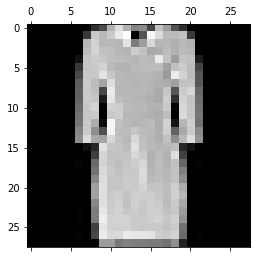

In [7]:
# podejrzenie przykładowych zdjęć
n = 9000
plt.gray()
plt.matshow(x_train[n])
print("Label: ", np.argmax(y_train[n]))

## Rozbudowa modelu sieci

In [9]:
# model konwolucyjnej sieci neuronowej
class modelCNN(object):
    
    def __init__(self, outSize, outAct, conv1Num, conv2Num, conv3Num, fcNum, lr, taskType):
       
        # inicjalizacja learnig rate'u
        self.lr = lr
        
        # Parametry sieci
        # wejscia leca od razu na warstwe ukryta
        
        # warstwy konwolucyjne
            # kernel 3*3
            # ilość cech na wejściu 1, ilość cech na wyjściu conv1Num
        self.W_conv1 = tf.Variable(tf.random.normal([3, 3, 1, conv1Num]))
            # biasów jest tyle ile cech wyjściowych z warstwy, czyli conv1Num
        self.b_conv1 = tf.Variable(tf.random.normal([conv1Num]))
        
            # druga warstwa konwolucyjna
        self.W_conv2 = tf.Variable(tf.random.normal([3, 3, conv1Num, conv2Num]))
        self.b_conv2 = tf.Variable(tf.random.normal([conv2Num]))
        
            # trzecia warstwa konwolucyjna
        self.W_conv3 = tf.Variable(tf.random.normal([3, 3, conv2Num, conv3Num]))
        self.b_conv3 = tf.Variable(tf.random.normal([conv3Num]))
        
        # warstwa fully connected
            # wagi, wielkość wejściowa taka ile mamy cech na ostatniej konwolucji razy wielkość cech po dwóch maxpool'ach
        self.W_fc = tf.Variable(tf.random.normal([4*4*conv3Num,fcNum]))
            # biasów tyle ile neuronów
        self.b_fc = tf.Variable(tf.zeros([fcNum]))
        
        # warstwa wyjściowa, 1 neuron z 10 wejściami
        self.W_out = tf.Variable(tf.random.normal([fcNum,outSize]))
        self.b_out = tf.Variable(tf.zeros([outSize]))

        # aktywacje zapamiętujemy na później
        self.outAct = outAct
        
         # optimizer
        self.optimizer = tf.optimizers.Adam(self.lr)
        
        # task type, regression or classification
        self.taskType = taskType
        
        # współczynnik dropout
        self.dropCoef = 1
        
        
    def predict(self, x):
        # feed forward
        # wejściowa warstwa, zmieniamy kształt pod konwolucje, standard NHWC, ilość zdjęć * wysokość zdjęcia * szerokość zdjęcia * kanały
        layer_in = tf.reshape(x, (-1, 28, 28, 1))
        
        # pierwsza warstwa konwolucyjna
            # konwolucja
            # strides oznacza przesuwanie kernela w każdym wymiarze, chcemy o 1 we wszystkich
        layer_conv1 = tf.nn.conv2d(layer_in, self.W_conv1, strides=[1, 1, 1, 1], padding='SAME')
        # po konwolucji otrzymujemy obraz o rozmiarze 28*28*ilość cech
            # dodanie biasów
        layer_conv1 = tf.nn.bias_add(layer_conv1, self.b_conv1)
            # aktywacja
        layer_conv1 = tf.nn.relu(layer_conv1)
            # maxpool, zmniejszamy obraz o połowę, czyli na 14*14
            # ksize oznacz wielkość okna maxpool'a
            # strides oznacza o ile będzie się to okno przesuwało w każdym wymiarze
        layer_conv1 = tf.nn.max_pool2d(layer_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # druga warstwa konwolucyjna
            # konwolucja
        layer_conv2 = tf.nn.conv2d(layer_conv1, self.W_conv2, strides=[1, 1, 1, 1], padding='SAME')
            # dodanie biasów
        layer_conv2 = tf.nn.bias_add(layer_conv2, self.b_conv2)
            # aktywacja
        layer_conv2 = tf.nn.relu(layer_conv2)
            # maxpool, zmniejszamy obraz o połowę, czyli na 7*7
        layer_conv2 = tf.nn.max_pool2d(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # trzecia warstwa konwolucyjna
            # konwolucja
        layer_conv3 = tf.nn.conv2d(layer_conv2, self.W_conv3, strides=[1, 1, 1, 1], padding='SAME')
            # dodanie biasów
        layer_conv3 = tf.nn.bias_add(layer_conv3, self.b_conv3)
            # aktywacja
        layer_conv3 = tf.nn.relu(layer_conv3)
            # maxpool, zmniejszamy obraz o połowę, czyli na 7*7
        layer_conv3 = tf.nn.max_pool2d(layer_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # aby pójść dalej musimy cechy spłaszczyć do wektora wartości, shape=[nieznana ilość zdjęć, ilość neuronów w fc]
        layer_flatten = tf.reshape(layer_conv3, [-1, self.W_fc.get_shape().as_list()[0]])
        
        # warstwa fully connected
            # mnożymy przez wagi i dodajemy biasy
        layer_fc = tf.add(tf.matmul(layer_flatten, self.W_fc), self.b_fc)
            # przechodzimy z sygnałem przez funkcję aktywacji
        layer_fc = tf.nn.relu(layer_fc)
            # dropout, wyłączamy losową część neuronów, o ile mniejsze od 1
        if self.dropCoef < 1.0:
            layer_fc = tf.nn.dropout(layer_fc, self.dropCoef)
        
        # warstwa wyjściowa
            # mnożymy przez wagi i dodajemy biasy
        layer_out = tf.add(tf.matmul(layer_fc, self.W_out), self.b_out)
            # przechodzimy z sygnałem przez funkcję aktywacji
            # rodzaj funkcji aktywacji zależy od parametru podczas tworzenia modelu
        if self.outAct != None:
            layer_out = self.outAct(layer_out)
        return layer_out
    
    def lossFun(self, y_pred, y_true):
        
        # zmiana kształtu referencji na potrzeby obliczeń macierzowych
        y_true = tf.reshape(y_true, (-1, self.b_out.shape[0]))
        if self.taskType == "class":
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))
        elif self.taskType == "reg":
            return tf.reduce_mean(tf.square(y_pred - y_true))
        else:
            print("Set taskType to 'reg' or 'class'")
    
    def fit(self, x, y_true):
        with tf.GradientTape() as t:
            current_loss = self.lossFun(self.predict(x), y_true)
        gradients = t.gradient(current_loss,[self.W_conv1, self.b_conv1,
                                             self.W_conv2, self.b_conv2,
                                             self.W_conv3, self.b_conv3,
                                             self.W_fc, self.b_fc,
                                             self.W_out, self.b_out])
        self.optimizer.apply_gradients(zip(gradients, [self.W_conv1, self.b_conv1,
                                                       self.W_conv2, self.b_conv2,
                                                       self.W_conv3, self.b_conv3,
                                                       self.W_fc, self.b_fc,
                                                       self.W_out, self.b_out]))
        # zwracamy błąd
        return current_loss

## Trening i test

In [10]:
# parametry modelu
# wielkość wyjścia
_outSize = 10
# aktywacja wyjścia
_outAct = None #tf.nn.relu
# ilość cech w pierwszej warstwie konwolucyjnej
_conv1Num = 8
# ilość cech w drugiej warstwie konwolucyjnej
_conv2Num = 16
# ilość cech w trzeciej warstwie konwolucyjnej
_conv3Num = 32
# ilość neuronów w warstwie fully connected
_fcNum = 256
# współczynnik uczenia, mały -> wolno, duży -> szybko
_lr = 0.01

# utworzenie nienauczonego modelu
myCNN = modelCNN(_outSize, _outAct, _conv1Num, _conv2Num, _conv3Num, _fcNum, _lr, "class") ### tu skonczylem rozkmine i edycje

epoch 0
  mean loss 932.9815673828125
  mean train acc 0.6316166666666667
  mean test acc 0.3049
epoch 1
  mean loss 2.316014528274536
  mean train acc 0.25311666666666666
  mean test acc 0.25020000000000003
epoch 2
  mean loss 2.0451717376708984
  mean train acc 0.2620166666666666
  mean test acc 0.28259999999999996
epoch 3
  mean loss 1.9615435600280762
  mean train acc 0.3204166666666667
  mean test acc 0.3246
epoch 4
  mean loss 1.8614141941070557
  mean train acc 0.37018333333333336
  mean test acc 0.4035
epoch 5
  mean loss 1.73542320728302
  mean train acc 0.42001666666666665
  mean test acc 0.4585
epoch 6
  mean loss 1.5789591073989868
  mean train acc 0.4796333333333333
  mean test acc 0.48059999999999997
epoch 7
  mean loss 1.4692680835723877
  mean train acc 0.5231166666666667
  mean test acc 0.5477
epoch 8
  mean loss 1.3836276531219482
  mean train acc 0.5530166666666667
  mean test acc 0.5226999999999999
epoch 9
  mean loss 1.3602017164230347
  mean train acc 0.5601166666

epoch 80
  mean loss 0.48818349838256836
  mean train acc 0.8863166666666666
  mean test acc 0.8658
epoch 81
  mean loss 0.480101615190506
  mean train acc 0.8868333333333336
  mean test acc 0.8727999999999999
epoch 82
  mean loss 0.4835457503795624
  mean train acc 0.8837
  mean test acc 0.8686999999999999
epoch 83
  mean loss 0.48857107758522034
  mean train acc 0.8828000000000001
  mean test acc 0.8631
epoch 84
  mean loss 0.4834185838699341
  mean train acc 0.8824000000000001
  mean test acc 0.8614
epoch 85
  mean loss 0.46928587555885315
  mean train acc 0.8869333333333332
  mean test acc 0.8678
epoch 86
  mean loss 0.4639538526535034
  mean train acc 0.8895833333333333
  mean test acc 0.8659999999999998
epoch 87
  mean loss 0.46297165751457214
  mean train acc 0.8880500000000001
  mean test acc 0.8662000000000001
epoch 88
  mean loss 0.45862263441085815
  mean train acc 0.8884333333333333
  mean test acc 0.8682999999999998
epoch 89
  mean loss 0.4635838270187378
  mean train acc 

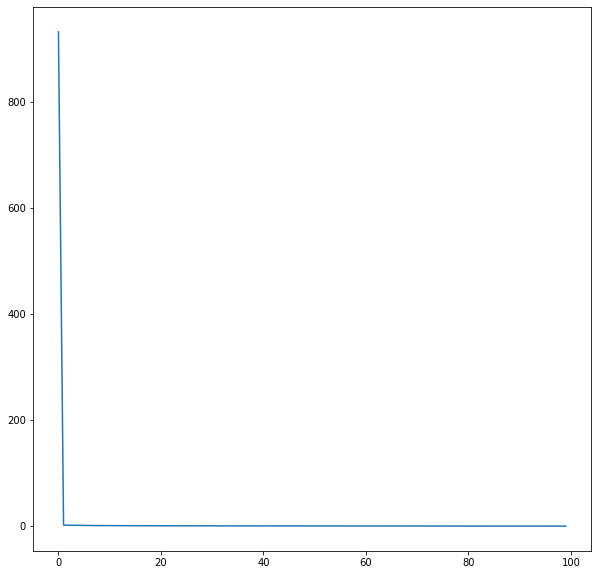

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.74      0.78      1000
           3       0.88      0.88      0.88      1000
           4       0.72      0.81      0.76      1000
           5       0.97      0.97      0.97      1000
           6       0.64      0.66      0.65      1000
           7       0.94      0.96      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [11]:
# lista przechowująca błąd po każdej epoce
lossList = []
# lista przechowująca skuteczności, te będziemy wyświetlać
accTrainList = []
accTestList = []
# lecimy po epokach i trenujemy na całym zbiorze treningowym
epochNum = 100
batchSize = 200
batchNum = int(x_train.shape[0]/batchSize)
lastBatch = x_train.shape[0]%batchSize
if lastBatch>0:
    batchNum += 1
for e in range(epochNum):
    # lista błędów w ramach jednej epoki
    tmpLossList = []
    # LISTA SKUTECZNOŚCI W RAMACH JEDNEJ EPOKI
    tmpTrainAccList = []
    # bierzemy kawałki datasetu
    for i in range(batchNum):
        batchStart = i*batchSize
        batchEnd = batchStart+batchSize
        if lastBatch>0 and i == batchNum-1:
            batchEnd = batchStart+lastBatch
        # ustawienie dropout'u do treningu, przykładowa wartość, 20% neuronów z warstwy fc wyłączamy
        myCNN.dropCoef = 0.2
        # trening
        tmpLossList.append(myCNN.fit(x_train[batchStart:batchEnd], y_train[batchStart:batchEnd]).numpy())
        # wyłączenie droput'u, do liczenia skuteczności chcemy wziąć całą sieć
        myCNN.dropCoef = 1
        # LICZENIE SKUTECZNOŚCI W RAMACH POJEDYNCZEGO BATCHA
            # wyjście z sieci
        tmpOneTrainOutput = myCNN.predict(x_train[batchStart:batchEnd])
            # wyznaczenie z wyjścia indeksów klas
        tmpOneTrainOutput = tf.nn.softmax(tmpOneTrainOutput).numpy().argmax(axis=1)
            # policzenie skuteczności i dodanie do listy
        tmpTrainAccList.append(accuracy_score(y_train[batchStart:batchEnd].argmax(axis=1), tmpOneTrainOutput))
    
    # średni błąd z wszystkich batchy wpisujemy na listę
    lossMean = np.array(tmpLossList).mean()
    lossList.append(lossMean)
    
    # LICZENIE ŚREDNIEJ SKUTECZNOŚCI Z BATCHY TESTOWYCH
        # lista do przechowania tymczasowych skuteczności na jednym batchu testowym
    tmpTestAccList = []
        # definiujemy wielkość batcha testowego
    testBatchSize = batchSize
        # ile będzie batchy w ramach zbioru testowego
    testBatchNum = int(x_test.shape[0]/testBatchSize)
        # czy będzie jakiś ostatni batch innej wielkości
    testLastBatch = x_test.shape[0]%testBatchSize
        # jeśli tak to zwiększamy liczbę wszystkich
    if testLastBatch>0:
        testBatchNum += 1
        #idziemy po batch'ach i testujemy
    for i in range(testBatchNum):
        # początek zakresu batcha
        batchStart = i*batchSize
        # koniec zakresu batcha
        batchEnd = batchStart+testBatchSize
        # jeśli jest top ostatni batch, innej wielkości, to zakres jest mniejszy
        if testLastBatch>0 and i == testBatchNum-1:
            batchEnd = batchStart+testLastBatch
        # liczymy wyjścia na danych testowych
        tmpOneTestOutput = myCNN.predict(x_test[batchStart:batchEnd])
        # wyznaczamy pojedyncze indeksy klas jakie otrzymaliśmy z modelu
        tmpOneTestOutput = tf.nn.softmax(tmpOneTestOutput).numpy().argmax(axis=1)
        # liczymy skuteczność porównując z referencją testową i dodajemy do listy tymczasowej
        tmpTestAccList.append(accuracy_score(y_test[batchStart:batchEnd].argmax(axis=1), tmpOneTestOutput))
        
    # DODAWANIE ŚREDNICH SKUTECZNOŚCI DO LIST
    # liczymy średnie z list tymczasowych i dodajemy do list głównych
    accTrainMean = np.array(tmpTrainAccList).mean()
    accTrainList.append(accTrainMean)
    accTestMean = np.array(tmpTestAccList).mean()
    accTestList.append(accTestMean)
    print("epoch {0}\n  mean loss {1}\n  mean train acc {2}\n  mean test acc {3}".format(e, lossMean, accTrainMean, accTestMean))
# zebrane błędy wyświetlamy
print("Wyjścia po treningu {0} epok:\n{1}\n\nReferencyjne wyjścia:\n{2}".format(
    epochNum, 
    tf.nn.softmax(myCNN.predict(x_test[:5])).numpy().argmax(axis=1), 
    y_test[:5].argmax(axis=1)))
plt.figure(figsize=(10,10))
plt.plot(lossList)
plt.show()

# testowanie
y_pred = tf.nn.softmax(myCNN.predict(x_test)).numpy()
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

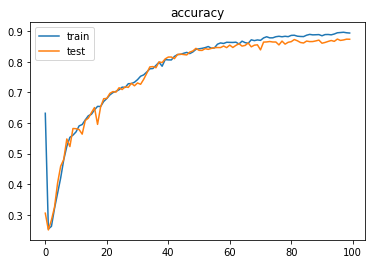

In [13]:
# wykres średnich skuteczności podczas treningu na zbiorze treningowym praz testowym
plt.plot(accTrainList)
plt.plot(accTestList)
plt.legend(["train", "test"])
plt.title("accuracy")
plt.show()

## wnioski
1. Model został rozszerzony o jedną warstwę konwolucyjną i działa prawidłowo
2. Spadek błędu podczas treningu zachowuje się odpowiednio dla optymalizatora ``Adam``
3. Zarejestrowane średnie wartości skuteczności na zbiorach ``train`` i ``test`` wskazują na bardzo dobry przebieg treningu. Model nie został przetrenowany.
4. Użycie warstwy ``dropout`` nie zaburzyło treningu, wręcz pomogło w lepszej generalizacji.